岩波本のコードを使った下記のQIITA参照 
https://qiita.com/0NE_shoT_/items/286a99d66cf6d3aaccf0


### 検証目的
アプリ利用を促進するCMを見たユーザーが、実際にアプリを利用するようになったかを検証したい  


## データ
### 共変量：X
TV視聴時間、性別や年齢など

### 群別を表す変数：Z 
CMを見たかどうか

### 目的変数: y
アプリ利用をしたか

# 手順

1. 傾向スコアを推定するモデル構築
2. 傾向スコアの推定モデルの精度確認
3. ATTの算出
4. 共変量の分布の確認

# import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


import statsmodels.api as sm


from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

import itertools
import time


# データ読み込み

In [6]:
data = pd.read_csv("q_data_x.csv")
data

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,0,0,1,0,24.5,1,0,0,...,0,0,0,0,1,0,0,1172.051927,97226,764
9996,0,1,0,0,1,0,24.5,1,0,0,...,0,0,0,0,1,0,0,1173.538255,97224,764
9997,0,1,0,0,1,0,24.5,1,0,0,...,0,0,0,0,1,0,0,1173.073186,97227,764
9998,0,1,0,0,1,0,24.5,1,0,0,...,0,0,0,0,1,0,0,1173.016481,97225,765


In [9]:
# 共変量
X = data[['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney','area_kanto', 'area_tokai', 'area_keihanshin', 
          'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
          'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4']]

# 群別変数
Z = data['cm_dummy']


# 傾向スコアを推定するモデル構築

In [10]:
exog = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=Z, exog=exog) # ロジスティック回帰
logit_res = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6


C:\Users\mchai\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# 傾向スコアの推定モデルの精度確認

In [16]:
# AUCの算出

ps = logit_res.predict(exog)


print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=ps)))
print('-----ps------\n',ps)

AUC = 0.792
-----ps------
 0       0.046495
1       0.254791
2       0.186736
3       0.227271
4       0.240950
          ...   
9995    0.214722
9996    0.214755
9997    0.214745
9998    0.214743
9999    0.214732
Length: 10000, dtype: float64


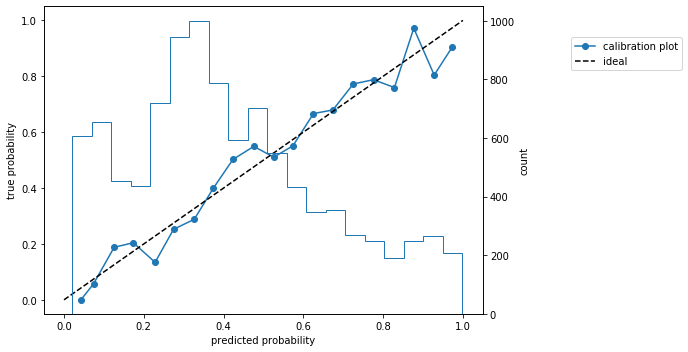

In [73]:
#キャリブレーションプロットを描画

_, ax1 = plt.subplots(figsize=(10, 5))


prob_true, prob_pred = calibration_curve(y_true=Z, y_prob=ps, n_bins=20)
ax1.plot(prob_pred, prob_true, marker='o', label='calibration plot')
ax1.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
ax1.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
ax1.set_xlabel('predicted probability')
ax1.set_ylabel('true probability')

ax2 = ax1.twinx()
ax2.hist(ps, bins=20, histtype='step', rwidth=0.9)
ax2.set_ylabel('count')
plt.tight_layout()
plt.show()

# ATTの算出

In [20]:
data.loc[data['cm_dummy']==1, 'gamedummy']

5428    0
5429    0
5430    0
5431    0
5432    0
       ..
9987    1
9988    1
9989    1
9990    1
9991    1
Name: gamedummy, Length: 4144, dtype: int64

In [21]:
# 群別変数Z=1のレコードの、結果変数Yのインデックス（行番号）を取得する
pd.Series(data.loc[data['cm_dummy']==1, 'gamedummy'].index)

0       5428
1       5429
2       5430
3       5431
4       5432
        ... 
4139    9987
4140    9988
4141    9989
4142    9990
4143    9991
Length: 4144, dtype: int64

In [32]:
# 群別変数Z=1のレコードの、結果変数Yのインデックス（行番号）を取得し、TGのデータ数分、ランダムに取得する
# returnは、行番号がランダムに並んだSeries

idx1 = pd.Series(data.loc[data['cm_dummy']==1, 'gamedummy'].index).sample(len(data.loc[data['gamedummy']==1]), replace=True, random_state=3)
idx0 = pd.Series(data.loc[data['cm_dummy']==0, 'gamedummy'].index).sample(len(data.loc[data['gamedummy']==1]), replace=True, random_state=3)
idx1

1688    7116
3321    8749
1667    7095
968     6396
789     6217
        ... 
2222    7650
2551    7979
1284    6712
1870    7298
2327    7755
Length: 740, dtype: int64

In [36]:
Z_tmp = np.r_[Z[idx1],Z[idx0]]
Z_tmp

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [44]:
# ATTの推定
"""ATT= TGにおける介入の効果"""

# 結果変数（アプリ見たかどうか）
Y = data['gamedummy']

# TGのレコード数
sample_size = len(data.loc[data['gamedummy']==1])
print(f"sample_size:{sample_size}")


ATT_list = []

# 1000回試行して、ATTの値の平均 ± x のかたちで算出する
for i in range(1000):

    # 群別変数Z=1のレコードの、結果変数の列の、インデックス（行番号）を取得し、ランダムにTGのデータ数分を抽出して並び替え
    idx1 = pd.Series(data.loc[data['cm_dummy']==1, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)
    
    # CGもTGと同じデータ数分の行番号をランダムに取得する
    idx0 = pd.Series(data.loc[data['cm_dummy']==0, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)
    
    
    # Z（CM見たかどうか）のデータフレームを結合する
    # TGとCGから抽出したランダムな行を結合する
    Z_tmp = np.r_[Z[idx1],Z[idx0]]

    # Y(共変量)のデータフレームを結合する
    Y_tmp = np.r_[Y[idx1],Y[idx0]]
    
    # ps=推定値のデータフレームを結合
    ps_tmp = np.r_[ps[idx1], ps[idx0]]
    
    
    """
    """
    w01_tmp = (1-Z_tmp)*ps_tmp / (1-ps_tmp)
    
    
    """
    ATT = E(Y1 | z=1) - E(Y0  | z=1)
   
　   E(Y1 | z=1) = 実績値
  　 E(Y0 | z=0) = 
    
   """
    
    E1 = np.mean(Y_tmp[Z_tmp==1])
    
    # ?????????????
    E0 = np.sum(Y_tmp * w01_tmp) / np.sum(w01_tmp)
    
    
    ATT = E1 - E0
    
    ATT_list.append(ATT)

sample_size:740


In [45]:
# ATTの

att_avg = np.mean(ATT_list)
att_std = np.std(ATT_list)
att_min = att_avg - att_std * 1.96
att_max = att_avg + att_std * 1.96

print(f'att_avg: {att_avg}')
print(f'att_std: {att_std}')
print(f'att_min: {att_min}')
print(f'att_max: {att_max}')


print('ATT = {:.3f} ± {:.3f} (s.d.={:.3f})'.format(np.mean(ATT_list), np.std(ATT_list)*1.96, np.std(ATT_list)))

att_avg: 0.024229549345693012
att_std: 0.015076824307727868
att_min: -0.00532102629745361
att_max: 0.053780124988839634
ATT = 0.024 ± 0.030 (s.d.=0.015)


# 共変量の分布の確認

In [46]:

def standardized_mean_difference(X1, X0):
    """標準化平均差(SMD）を算出する"""

    N1 = len(X1)
    N0 = len(X0)
    s_pool = ((N1-1)*np.var(X1)+(N0-1)*np.var(X0))/(N1+N0-2)

    return (np.mean(X1)-np.mean(X0))/np.sqrt(s_pool)


def smd_on_the_treated(X, Z, ps): 
    """傾向スコアを用いた調整前後のSMDを計算する関数"""
    
    
    X1 = X[Z==1]
    X0 = X[Z==0]
    
    ps0 = ps[Z==0]
    
    #_??????
    X10 = X0*ps0/(1-ps0)
    
    
    # マッチング調整前のSMD：TGとCGの間のSMD
    smd_before = standardized_mean_difference(X1, X0)
    
    # マッチング調整後のSMD: TGと、CGのうちTGとマッチングしたデータ群の間のSMD
    smd_after = standardized_mean_difference(X1, X10)


    return smd_before, smd_after

In [48]:
X.columns

Index(['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc',
       'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3',
       'fam_str_dummy4'],
      dtype='object')

In [52]:
smd_list = []



# 1共変量ごとに、その共変量のデータセット・Zのデータセット・傾向スコアのデータセットの3つのデータでSMDを算出して格納する
for col_name in X.columns:
    smd_before, smd_after = smd_on_the_treated(X=X[col_name], Z=Z, ps=ps)
    smd_list.append([col_name, smd_before, smd_after])


smd_list

[['TVwatch_day', 0.8014732533686983, -0.023691205503708377],
 ['age', 0.1513975252519879, 0.04551608310468542],
 ['sex', -0.15535667250632235, 0.024729396976535308],
 ['marry_dummy', 0.0835653179466395, 0.10002263316838318],
 ['child_dummy', 0.0050780515278276, 0.13993082936241302],
 ['inc', -0.10315940099520923, 0.030819476145570037],
 ['pmoney', -0.0040623403990144484, 0.0351092865613715],
 ['area_kanto', 0.2378880616448638, 0.0684135764782083],
 ['area_tokai', -0.0996939265744325, -0.04702668134023879],
 ['area_keihanshin', -0.5863509984132397, 0.1042744210257915],
 ['job_dummy1', -0.16797550020401764, 0.0036713872656061854],
 ['job_dummy2', -0.030224646262133767, 0.022785406946811592],
 ['job_dummy3', 0.06455907813719136, 0.0916094276143794],
 ['job_dummy4', 0.018801725685078218, 0.0506942380222613],
 ['job_dummy5', 0.20337628689433745, 0.16184398563086008],
 ['job_dummy6', 0.06326394230975375, 0.022166119120759442],
 ['job_dummy7', -0.08079646381108715, 0.058065848480471784],
 ['f

In [56]:
# smdリストをDFに変換
smd_df = pd.DataFrame(data=smd_list, columns=['covariate', 'SMD(before)', 'SMD(after)'])
smd_df

,covariate,SMD(before),SMD(after)
0,TVwatch_day,0.801473,-0.023691
1,age,0.151398,0.045516
2,sex,-0.155357,0.024729
3,marry_dummy,0.083565,0.100023
4,child_dummy,0.005078,0.139931
5,inc,-0.103159,0.030819
6,pmoney,-0.004062,0.035109
7,area_kanto,0.237888,0.068414
8,area_tokai,-0.099694,-0.047027
9,area_keihanshin,-0.586351,0.104274


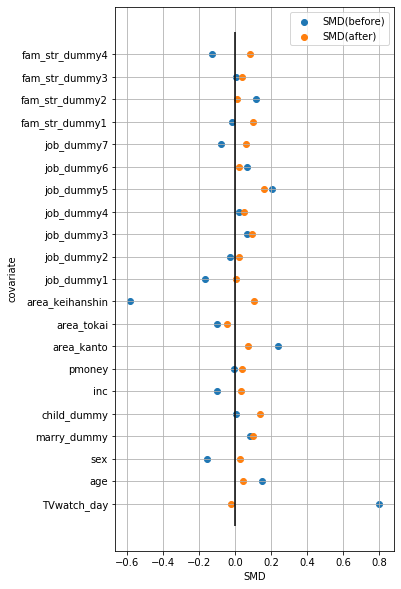

In [72]:
# 描画


plt.figure(figsize=(5,10))

# データ
plt.scatter(smd_df['SMD(before)'], smd_df['covariate'], label='SMD(before)')
plt.scatter(smd_df['SMD(after)'], smd_df['covariate'], label='SMD(after)')

# X=０に縦線を引く
# X.shape ➡　Xの行数(10000)、列数(21)
plt.vlines(x=[0], ymin=-1, ymax=X.shape[1])


# グリッドを引く
plt.grid()


plt.xlabel('SMD')
plt.ylabel('covariate')


plt.legend()

In [64]:
X.shape

(10000, 21)